## Workbook: Quantifying Incrementality: A/B Testing, Mean as a Model, Statistical Analysis, and Confidence Intervals

WIP Version: 1 <br>
Last Updated:  05/16/2024 <br>
This workbook is the companion code to this <a href="https://decisionsciences.blog/2024/05/16/workbook-quantifying-incrementality-a-b-testing-mean-as-a-model-statistical-analysis-and-confidence-intervals/" target="blank">blog post</a> on decisionsciences.blog</br> 

***

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# colors for plotting
ppt_grey = "#5B738B"
ppt_dark_grey = "#666666"
ppt_medium_grey = "#999999"
ppt_lightgrey = "#CCCCCC"
ppt_blue = "#1B90FF"
ppt_red = "#EE3939"
ppt_rasp = "#FA4F96"
ppt_pink = "#F31DED"

## Introduction

#### Scenario
To boost both customer loyalty and profitability, your company has introduced a rewards program that incentivizes repeat purchases and increased engagement. This program is designed to appeal to your existing customer base, offering points, discounts, and exclusive access to new products based on customer activity and purchase history. The primary promotional tool for this loyalty program is targeted email campaigns, which aim to educate customers about the benefits of participating in the program and encourage them to take actions that increase their rewards. Initial analyses suggest that customers who receive these promotional emails show a higher AOV compared to those who do not, indicating potential effectiveness of the campaign. However, a deeper dive into the data reveals that emails may have been sent disproportionately to customers already exhibiting higher engagement or purchasing frequencies.

This insight suggests a selection bias that could skew the perceived impact of the loyalty program on AOV. The higher AOV observed in the targeted group might not solely be a result of the loyalty program but also of their inherent purchasing behaviors. To isolate the true effect of the loyalty program on AOV, it is crucial to implement a randomized control trial. By randomly distributing the promotional emails across a broad and varied customer base, you ensure that any observed differences in AOV post-campaign are directly attributable to the program itself, rather than underlying differences in customer behavior. This methodological approach will provide a clear and unbiased assessment of how effectively the loyalty program enhances customer spending and retention, guiding more accurate and strategic enhancements to the program.

Here’s how we set it up for our mini use case:

- **Control Group** received the traditional offer
- **Treatment Group** received new promotional offer

For simplicity, there are 100 customers in each group that made purchases. 

**Objective:** to measure the Incremental Gain and Lift from the experiment to see if the new offer significantly impacts the Average Order Value (AOV).

#### Data Generation
- Control Group: 100 customers, mean average order value = 75.00, standard deviation = 8.00
- Treatment Group : 100 customers, mean average order value = 80.00, standard deviation = 10.00


In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate sample data
group_a = np.random.normal(75, 8, 100)
group_b = np.random.normal(80, 10, 100)

# Calculate the AOV
mean_a = np.mean(group_a)
mean_b = np.mean(group_b)

# print results
print(f"Average Order Value (Control): {mean_a:.2f}")
print(f"Average Order Value (Treatment): {mean_b:.2f}")

Average Order Value (Control): 74.17
Average Order Value (Treatment): 80.22


#### Incremental Gain & Lift

Incremental Gain typically refers to the absolute difference between the performance metrics of two groups (e.g., experimental vs. control group). It can be expressed as:

$
\text{Incremental Gain} = \text{Metric}_{\text{treatment}} - \text{Metric}_{\text{control}}
$

Where:
- $\text{Metric}_{\text{treatment}}$ is the average outcome measure of the treatment group.
- $\text{Metric}_{\text{control}}$ is the average outcome measure of the control group.

Lift as a percentage measures the relative increase in a metric due to the treatment, expressed as a percentage of the control group's metric. The formula is:

$
\text{Lift (%)} = \left( \frac{\text{Metric}_{\text{treatment}}  -  \text{Metric}_{\text{control}}}{\text{Metric}_{\text{control}}} \right) \times 100\%
$

##### Plot the Results Side by Side)

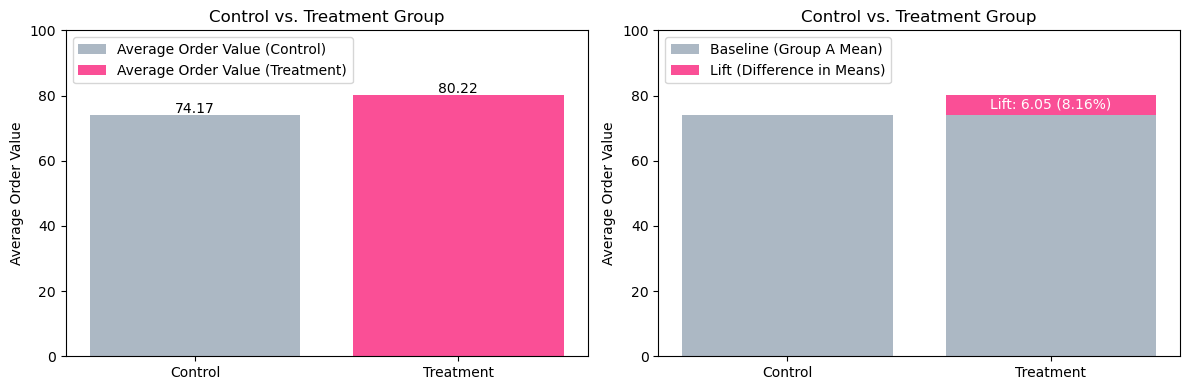

In [4]:
# Set up a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

groups = ['Control', 'Treatment']
means = [mean_a, mean_b]
baseline_lift = [mean_a, mean_a]
# Calculate incremntality and lift
difference_means = mean_b - mean_a
lift_percentage = (difference_means / mean_a) * 100

# Chart 1 on the left
axes[0].bar(groups[0], means[0], color=ppt_grey, alpha=0.5, label='Average Order Value (Control)')  # Adjusted alpha here for the first bar
axes[0].bar(groups[1], means[1], color=ppt_rasp, label='Average Order Value (Treatment)')  # Second bar remains the same
axes[0].set_ylabel('Average Order Value')
axes[0].set_title('Control vs. Treatment Group')
for i, v in enumerate(means):
    axes[0].text(i, v + 0.5, f"{v:.2f}", ha='center')
axes[0].legend(loc='upper left')

# Chart 2 on the right
axes[1].bar(groups, baseline_lift, color=ppt_grey, alpha=.5, label='Baseline (Group A Mean)')
axes[1].bar(groups, [0, difference_means], bottom=baseline_lift, color=ppt_rasp, label='Lift (Difference in Means)')
axes[1].text(1, mean_a + difference_means / 2, f"Lift: {difference_means:.2f} ({lift_percentage:.2f}%)", ha='center', va='center', color='white')
axes[1].set_ylabel('Average Order Value')
axes[1].set_title('Control vs. Treatment Group')
axes[1].legend(loc='upper left')

# Adjust the y-limits 
max_ylim = max(max(means) + 10, mean_a + difference_means + 10)
axes[0].set_ylim(0, 100)
axes[1].set_ylim(0, 100)

# Display the plot
plt.tight_layout()
plt.show()


##### Plot the Results (Vertically)

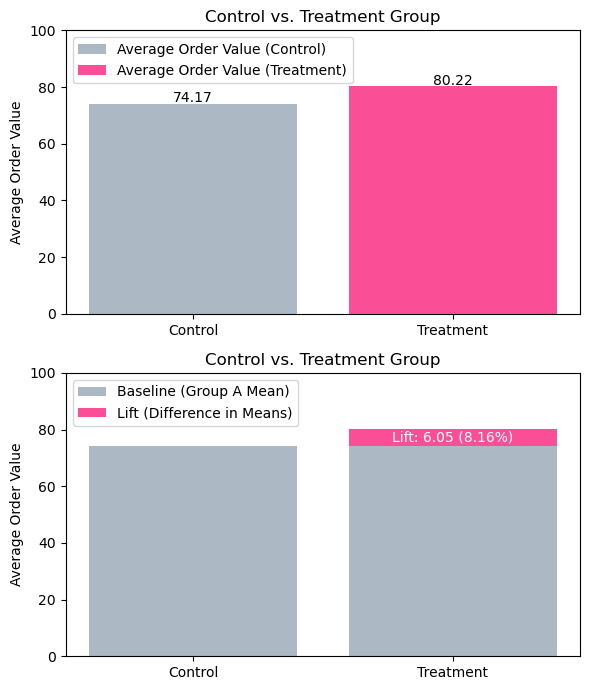

In [5]:
# Set up a figure with two subplots side by side
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,7))

groups = ['Control', 'Treatment']
means = [mean_a, mean_b]
baseline_lift = [mean_a, mean_a]

# Chart 1 on the left
axes[0].bar(groups[0], means[0], color=ppt_grey, alpha=0.5, label='Average Order Value (Control)')  # Adjusted alpha here for the first bar
axes[0].bar(groups[1], means[1], color=ppt_rasp, label='Average Order Value (Treatment)')  # Second bar remains the same
axes[0].set_ylabel('Average Order Value')
axes[0].set_title('Control vs. Treatment Group')
for i, v in enumerate(means):
    axes[0].text(i, v + 0.5, f"{v:.2f}", ha='center')
axes[0].legend(loc='upper left')

# Chart 2 on the right
axes[1].bar(groups, baseline_lift, color=ppt_grey, alpha=.5, label='Baseline (Group A Mean)')
axes[1].bar(groups, [0, difference_means], bottom=baseline_lift, color=ppt_rasp, label='Lift (Difference in Means)')
axes[1].text(1, mean_a + difference_means / 2, f"Lift: {difference_means:.2f} ({lift_percentage:.2f}%)", ha='center', va='center', color='white')
axes[1].set_ylabel('Average Order Value')
axes[1].set_title('Control vs. Treatment Group')
axes[1].legend(loc='upper left')

# Adjust the y-limits 
max_ylim = max(max(means) + 10, mean_a + difference_means + 10)
axes[0].set_ylim(0, 100)
axes[1].set_ylim(0, 100)

# Display the plot
plt.tight_layout()
plt.show()


#### Preliminary Summary

In [6]:
# print results
print(f"Average Order Value (Control): {mean_a:.2f}")
print(f"Average Order Value (Treatment): {mean_b:.2f}")
print(f"Incremental Gain (Treatment over Control): {difference_means:.2f}")
print(f"Lift (Treatment over Control): {lift_percentage:.2f}%")

Average Order Value (Control): 74.17
Average Order Value (Treatment): 80.22
Incremental Gain (Treatment over Control): 6.05
Lift (Treatment over Control): 8.16%


## The Mean as a Model

The equation below represents a fundamental approach in statistics and modeling, where the observed data is considered as a function of an underlying model plus some error. This framework is foundational in many statistical models, including linear regression.

Here’s how you can generally express this concept in equation form:

#### General Equation:

$ \text{outcome}_i = \text{model}_i + \text{error}_i $

Where:
- $ \text{outcome}_i $ represents the observed data point for the \(i\)-th observation.
- $ \text{model}_i $ represents the predicted value by the model for the \(i\)-th observation.
- $ \text{error}_i $ represents the deviation of the observed outcome from the model prediction for the \(i\)-th observation.

This equation succinctly captures the essence that the actual observed outcome is the sum of the predicted value based on some statistical model and some error or residual that accounts for the difference between the observed and predicted values. The error term encompasses all the variation in the outcome that the model does not explain.  

We can think of the 'model' as the signal and the 'error' as the noise.  We want the signal to be strong (larger) relative to the error. In fact, the t-statistic used in the t-test (which we cover below) represents exaclty this idea. 

In a specific context like an A/B test comparing two means, this model could further specify the mean of each group:

$ \text{outcome}_{iA} = \overline{X}_A + \text{error}_{iA} $

$ \text{outcome}_{iB} = \overline{X}_B + \text{error}_{iB} $

Here, $ \overline{X}_A $ and $ \overline{X}_B $ represent the mean outcomes for groups A and B, respectively, and are part of the "model" that predicts the outcome based on the group average. The errors $ \text{error}_{iA} $ and $ \text{error}_{iB} $ are the individual deviations from these group means.


## Statistical Analysis

The visualizations below aid us in understanding the distribution and relative position of each group's mean AOV scores.

##### PLot the distribution of scores for the Control and Test Groups

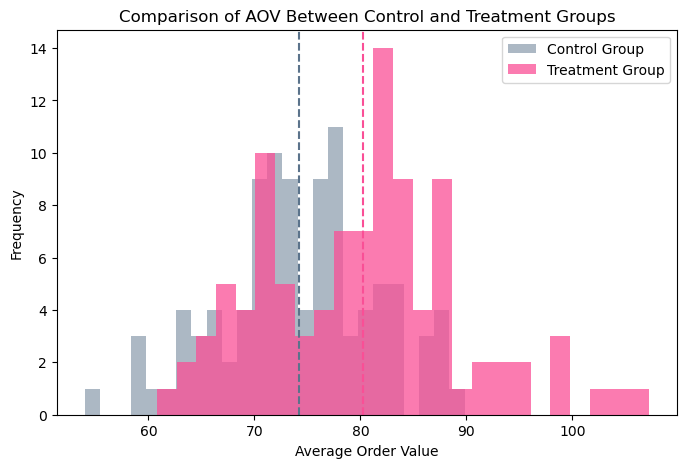

In [7]:
# Create histograms for visualization
plt.figure(figsize=(8, 5))
plt.hist(group_a, alpha=0.5, label='Control Group', bins=25, color=ppt_grey)
plt.hist(group_b, alpha=0.75, label='Treatment Group', bins=25, color=ppt_rasp)
plt.axvline(np.mean(group_a), color=ppt_grey, linestyle='dashed', linewidth=1.5)
plt.axvline(np.mean(group_b), color=ppt_rasp, linestyle='dashed', linewidth=1.5)
plt.title('Comparison of AOV Between Control and Treatment Groups')
plt.xlabel('Average Order Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


#### Visualize the spread around the mean for the Control and Test Groups

The spread or variance of a simple mean model illustrates how the goodness of fit of a model can be measured.  Larger deviation from the mean is indicates increased variance and a poorer fit overall.

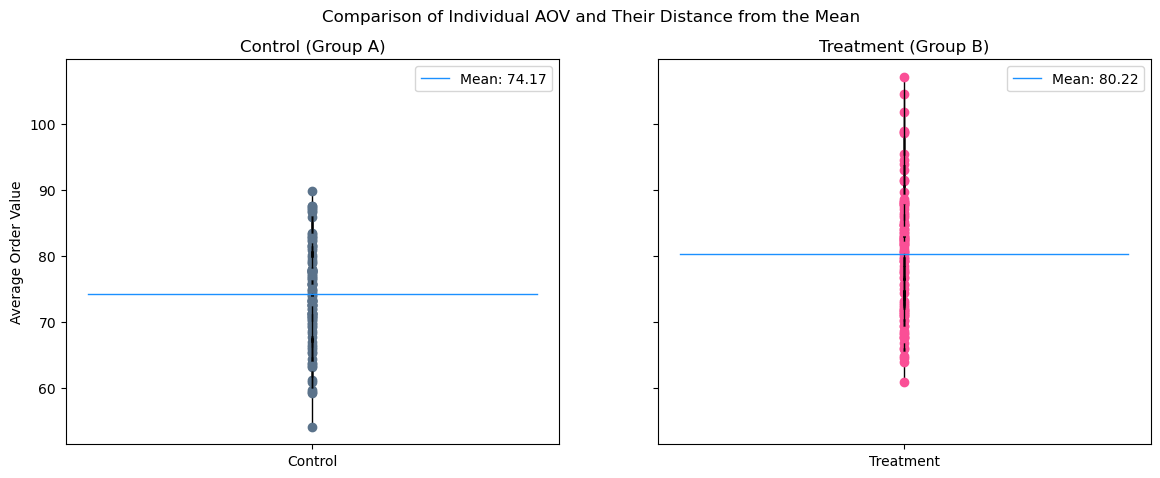

In [8]:
# Set up the figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

# Plot for Control Group
for sample in group_a:
    axes[0].plot([1, 1], [mean_a, sample], 'k-', lw=1)  # Line from the mean to the sample
    axes[0].plot(1, sample, marker='o', color=ppt_grey)  # Separate marker and color for Group A
axes[0].plot([0.9, 1.1], [mean_a, mean_a], color=ppt_blue, lw=1, label=f'Mean: {mean_a:.2f}')  # Mean line
axes[0].set_title('Control (Group A)')
axes[0].set_xticks([1])
axes[0].set_xticklabels(['Control'])
axes[0].set_ylabel('Average Order Value')
axes[0].legend()

# Plot for Test Group
for sample in group_b:
    axes[1].plot([1, 1], [mean_b, sample], 'k-', lw=1)  # Line from the mean to the sample
    axes[1].plot(1, sample, marker='o', color=ppt_rasp)  # Separate marker and color for Group B
axes[1].plot([0.9, 1.1], [mean_b, mean_b], color=ppt_blue, lw=1, label=f'Mean: {mean_b:.2f}')  # Mean line
axes[1].set_title('Treatment (Group B)')
axes[1].set_xticks([1])
axes[1].set_xticklabels(['Treatment'])
axes[1].legend()

plt.suptitle('Comparison of Individual AOV and Their Distance from the Mean')
plt.show()


##### Visualize the error (distance from mean) for each customer for the Control and Test Groups

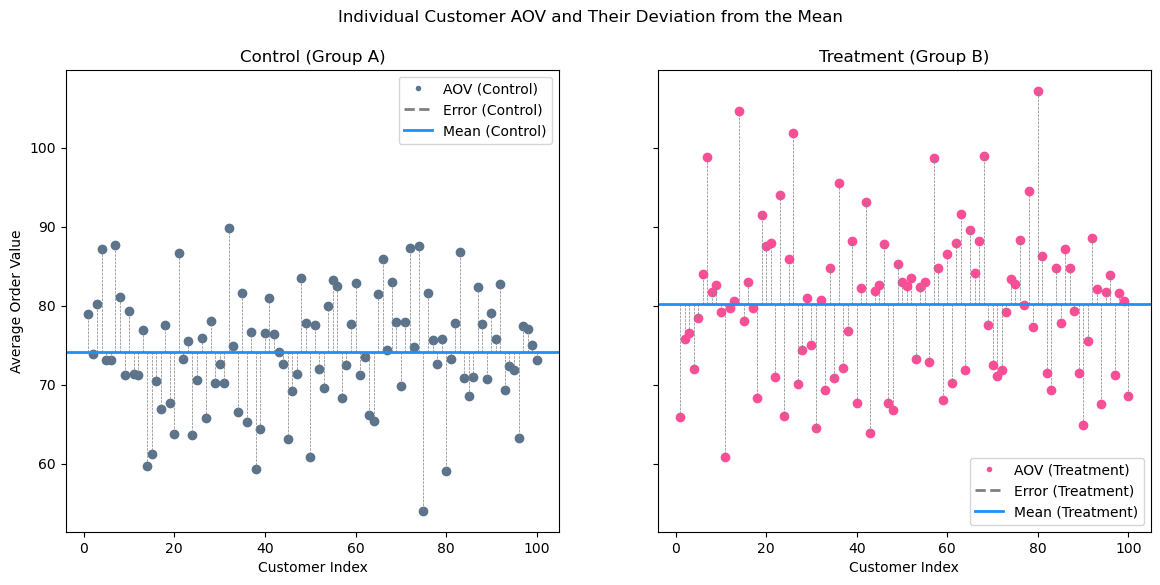

In [9]:
from matplotlib.lines import Line2D  # For creating custom legend handles

# Set up the figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# Indices for x-axis
indices_a = np.arange(len(group_a)) + 1  # +1 to start from 1 instead of 0 on the x-axis
indices_b = np.arange(len(group_b)) + 1

# Plot for Group A
axes[0].scatter(indices_a, group_a, color=ppt_grey, label='AOV (Control)')  # Individual scores
axes[0].vlines(indices_a, mean_a, group_a, color='gray', linestyle='dashed', lw=0.5)  # Lines showing deviation from mean
axes[0].axhline(mean_a, color=ppt_blue, lw=2, label=f'Mean: {mean_a:.2f}')  # Mean line
axes[0].set_title('Control (Group A)')
axes[0].set_xlabel('Customer Index')
axes[0].set_ylabel('Average Order Value')

# Plot for Group B
axes[1].scatter(indices_b, group_b, color=ppt_rasp, label='AOV (Treatment)')  # Individual scores
axes[1].vlines(indices_b, mean_b, group_b, color='gray', linestyle='dashed', lw=0.5)  # Lines showing deviation from mean
axes[1].axhline(mean_b, color=ppt_blue, lw=2, label=f'Mean: {mean_b:.2f}')  # Mean line
axes[1].set_title('Treatment (Group B)')
axes[1].set_xlabel('Customer Index')

# Create custom legend handles for Group A
score_handle_a = Line2D([0], [0], marker='o', color='w', markerfacecolor=ppt_grey, markersize=5, label='AOV (Control)')
error_handle_a = Line2D([0], [0], linestyle='--', color='gray', lw=2, label='Error (Control)')
mean_handle_a = Line2D([0], [0], linestyle='-', color=ppt_blue, lw=2, label='Mean (Control)')

# Create custom legend handles for Group B
score_handle_b = Line2D([0], [0], marker='o', color='w', markerfacecolor=ppt_rasp, markersize=5, label='AOV (Treatment)')
error_handle_b = Line2D([0], [0], linestyle='--', color='gray', lw=2, label='Error (Treatment)')
mean_handle_b = Line2D([0], [0], linestyle='-', color=ppt_blue, lw=2, label='Mean (Treatment)')

# Adding legends with custom handles
axes[0].legend(handles=[score_handle_a, error_handle_a, mean_handle_a], loc='upper right')
axes[1].legend(handles=[score_handle_b, error_handle_b, mean_handle_b], loc='lower right')

plt.suptitle('Individual Customer AOV and Their Deviation from the Mean')
plt.show()

#### Step-by-Step Calculation of Standard Error from the Residuals:

The sequence below outlines how the error terms from the individual observations contribute to the overall estimation of variability and uncertainty in comparing the means, directly influencing the calculation of the t-test statistic (calculated in the next step) and the conclusions that can be drawn about the group means based on sample data. 

1. **Calculate the Sum of Squared Errors (Variance) of Each Group:**
   first, we calculate the sum of squared errors, or variance, for each group. The variance is the average error between the mean and the AOV score for each customer(as plotted above).  This is a good measure of the accuracy of a model. We square the differences so that the positive and negative scores don't cancel each other out.  Because the Sum of Squared Errors is clearly dependent upon the amount of data that has been collected - i.e. the more data points the higher the sum of squares - we then must calculate the average error by dividing by the number of records. The variance for each group is the average of the squared differences from the mean (as plotted above), reflecting the average squared $ \text{error}_i $ for each group:
   
   $
   s^2_A = \frac{\sum (\text{outcome}_{iA} - \overline{X}_A)^2}{n_A - 1}
   $
   
   $
   s^2_B = \frac{\sum (\text{outcome}_{iB} - \overline{X}_B)^2}{n_B - 1}
   $
   
   where $ n_A $ and $ n_B $ are the sample sizes for groups A and B, respectively.

2. **Calculate Standard Error of Each Mean:**
    the standard error of the mean for each group is the square root of the variance divided by the sample size. The one problem with the variance of a measure (as calculated above) is that it is reported in united squared, so we must take the square root of the variance so that the measure of average error is in the same units as the original measure:
   
   $
   \text{SE}_A = \sqrt{\frac{s^2_A}{n_A}}
   $
   
   $
   \text{SE}_B = \sqrt{\frac{s^2_B}{n_B}}
   $


In the context of a t-test (below), especially when comparing two means, the error term plays a crucial role in calculating the standard error of the difference between the means. The standard error measures the variability or standard deviation of the sampling distribution of a statistic, in this case, the difference between two group means. Here’s how it is typically calculated:

3. **Calculate Standard Error of the Difference Between Means:**
   The standard error of the difference between the two means is calculated by summing the variances of each group's mean and taking the square root of this sum:
   
   $
   \text{SE}_{\overline{X}_A - \overline{X}_B} = \sqrt{\text{SE}_A^2 + \text{SE}_B^2}
   $
   
   This formula derives from the property of variances where the variance of the sum (or difference) of independent variables is the sum of their variances.

4. **Use in T-test Statistic:**
   The t-test statistic is then calculated by dividing the difference between the group means by the standard error of this difference:
   
   $
   t = \frac{\overline{X}_A - \overline{X}_B}{\text{SE}_{\overline{X}_A - \overline{X}_B}}
   $
   
This statistic follows a t-distribution with degrees of freedom approximated using the Welch-Satterthwaite equation if the variances are unequal or simply $ n_A + n_B - 2 $ if the variances are assumed equal.

This sequence outlines how the error terms from the individual observations contribute to the overall estimation of variability and uncertainty in comparing the means, directly influencing the calculation of the t-test statistic and the conclusions that can be drawn about the population means based on sample data. If you need further explanation or examples, feel free to ask!

### The T-Test

A **T-test** is a type of statistical test that is used to compare the means of two groups to determine if there is a statistically significant difference between them. It is one of the most commonly used tests for analyzing whether two groups, such as those in an A/B Test, are different from each other in terms of their average outcomes. It assumes that the data are approximately normally distributed and that the variances of the two groups are equal, though there are variations of the t-test (like Welch's t-test) that do not assume equal variances.

The t-test provides a p-value, which tells us whether the observed differences between the groups are statistically significant or if they occurred by chance. 

Here’s what the outcome typically signifies:

- **P-Value**: This value helps determine the significance of the results. A common threshold for significance is 0.05:
  - **If p < 0.05**: The difference between the groups is statistically significant. This means it is unlikely that any difference in means is due to random chance.
  - **If p ≥ 0.05**: There is not enough evidence to suggest a statistically significant difference between the means.

In practice, t-tests help in making informed decisions in various fields such as medicine, psychology, business, and any field where comparing two groups’ means is necessary. This approach enables practitioners and researchers to assess the effectiveness of interventions, treatments, or changes in policy or practice based on evidence.


#### Test Statistic

The t-statistic in a t-test measures the ratio of the signal (difference between the means of the two groups being compared) to the noise (variability or dispersion within each group). It essentially tells us how far the observed difference between group means is from the expected difference (zero). 

Here’s how this works and why a larger ratio indicates a more statistically significant result:

##### Signal to Noise Ratio

- **Signal**: In the case of the t-test, the signal is the difference between the sample means of two groups. This difference is what we are testing—whether it is statistically significant or not. The signal reflects the actual effect or impact of the intervention or difference between groups that we are studying.
- **Noise**: The noise is represented by the standard error of the difference between the means. This standard error encompasses the variability or dispersion within the sample data. It accounts for how spread out the individual observations are around their respective sample means, considering the sample size of each group.

In simple terms, the formula for the test statistic in a two-sample t-test looks like this:

$
t = \frac{\text{Difference between sample means (Signal)}}{\text{Standard error of the difference (Noise)}}
$

The actual test statistic for a t-test is calculated using the sample means $\overline{X}_1$ and $\overline{X}_2$ and their standard errors. The formula for the t-statistic in the case of comparing two independent means is:

$ t = \frac{(\overline{X}_1 - \overline{X}_2) - (\mu_1 - \mu_2)}{\text{SE}_{\overline{X}_1 - \overline{X}_2}} $

Under the null hypothesis, $\mu_1 - \mu_2 = 0$, so the formula simplifies to:

$ t = \frac{\overline{X}_1 - \overline{X}_2}{\text{SE}_{\overline{X}_1 - \overline{X}_2}} $

This formula measures how many standard errors the difference between the sample means $\overline{X}_1 - \overline{X}_2$ is from 0, the hypothesized difference under the null hypothesis. If the actual difference between the sample means is exactly as predicted under the null hypothesis (zero), the t-statistic will be zero. If the difference is greater or less than zero by a margin that exceeds what we might expect by chance alone (given the variability in the data as measured by the standard error), the t-statistic will move away from zero, potentially leading to the rejection of the null hypothesis.

In summary:
- The **t-distribution** provides a framework to evaluate how extreme the test statistic is. If the null hypothesis is true, this distribution predicts how the test statistic should behave purely due to sampling variability.
- The **test statistic** itself quantifies the actual observed effect (e.g., difference in means), standardized in a way that can be compared against the t-distribution. If this statistic falls into the critical regions of the t-distribution (the tails), it suggests that such an extreme result is unlikely under the null hypothesis, leading us to consider rejecting the null hypothesis.


This methodological approach allows statisticians and researchers to make informed decisions about the significance of their findings based on the properties of the data and the outcomes of their experiments or studies.

In [10]:
# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(group_b, group_a)

print(f"Test Statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.5f}")

Test Statistic: 5.05
p-value: 0.00000


##### Interpretation
- The t-statistic is quite large and negative, indicating that Group B scored significantly higher than Group A.
- The p-value is much smaller than our significance level $ \alpha = 0.05 $. This tells us that the difference in means is statistically significant, and we can reject the null hypothesis $ H_0 $ that there is no difference between the two groups.

#### The T-Distribution 

In crude terms, we can think about the distributions, like the ones plotted below, as a theoretical or hypothetical distribution that models what the differences in sample means *would* look like if the null hypothesis were true. It's based on the properties of your data -- specifically, the sample size and the sample standard deviations. It takes into account the uncertainty and variability <i>expected</i> in the sampling process. More precisely, the t-distribution under the null hypothesis models the expected distribution of the test statistic (e.g., the difference in sample means, standardized by the standard error of the difference) if there 'really is no difference between the groups (or no effect)'. This allows us to see how "extreme" the actual observed statistic is in the context of what would be expected by random chance alone.

##### Two-Sided Test

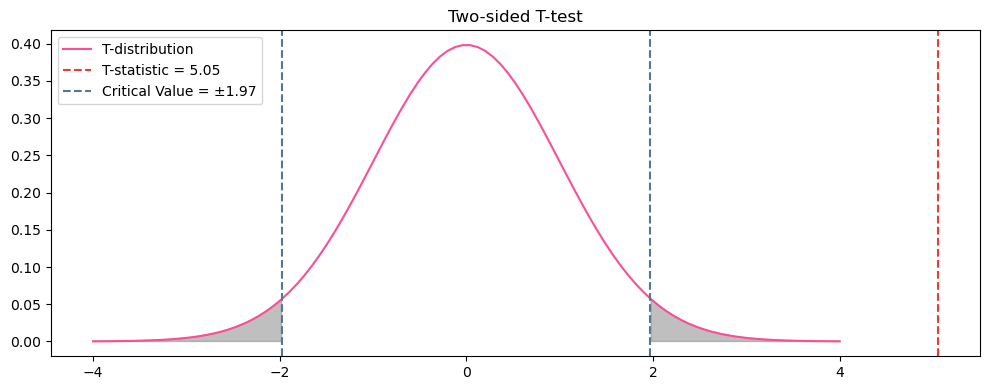

Mean Difference in Scores: 6.05
Difference Standard Deviation: 1.19
Critical Value (Left): -1.972
Critical Value (Right): 1.972
Test Statistic: 5.05

--------------------------------------------------------------------------------------------------------------------


In [11]:
# Degrees of freedom
df = len(group_a) + len(group_b) - 2

# Mean and standard deviation of the differences
mean_diff = np.mean(group_b) - np.mean(group_a)
std_diff = np.sqrt((np.std(group_a)**2 / len(group_a)) + (np.std(group_b)**2 / len(group_b)))
# Critical t-values for two-tailed test at alpha = 0.05
t_critical_left = stats.t.ppf(0.025, df)  # Left tail critical value
t_critical_right = stats.t.ppf(0.975, df)  # Right tail critical value

# Perform two-sided t-test
two_sided_test = stats.ttest_ind(group_b, group_a)  # Note the order of groups

# T-distribution plot
t_values = np.linspace(-4, 4, 100)
t_distribution = stats.t.pdf(t_values, df)

# Plotting both tests side-by-side
plt.figure(figsize=(10, 4))

# Two-sided t-test plot
plt.subplot(1, 1, 1)
plt.plot(t_values, t_distribution, label="T-distribution", color=ppt_rasp)
plt.axvline(x=two_sided_test.statistic, color=ppt_red, linestyle='--', label=f'T-statistic = {two_sided_test.statistic:.2f}')
critical_value_two_sided = stats.t.ppf(1 - 0.025, df)
plt.axvline(x=critical_value_two_sided, color=ppt_grey, linestyle='--', label=f'Critical Value = ±{critical_value_two_sided:.2f}')
plt.axvline(x=-critical_value_two_sided, color=ppt_grey, linestyle='--')
plt.fill_between(t_values, t_distribution, where=(t_values < -critical_value_two_sided) | (t_values > critical_value_two_sided), color='gray', alpha=0.5)
plt.title("Two-sided T-test")
plt.legend()

plt.tight_layout()
plt.show()

two_sided_test
print(f"Mean Difference in Scores: {mean_diff:.2f}")
print(f"Difference Standard Deviation: {std_diff:.2f}")
print(f"Critical Value (Left): {t_critical_left:.3f}")
print(f"Critical Value (Right): {t_critical_right:.3f}")
print(f"Test Statistic: {t_stat:.2f}")
print("")
print("--------------------------------------------------------------------------------------------------------------------")

- The **grey shaded areas** represent the critical regions for a two-tailed test at a significance level $\alpha$ of 0.05. If the t-statistic falls in these areas, we reject the null hypothesis.
- The **red dashed line** represents our calculated t-statistic of \(5.05\), which falls in the left critical region.
- The **black dashed lines** mark the critical values at \(-1.97\) and \(1.97\), indicating the boundaries beyond which we consider the results statistically significant if the t-statistic falls outside these values.

The **difference between means** is \(6.05\), with a **standard error** of \(1.19\). Given that the t-statistic is well within the critical region, this confirms that the difference in means is not only statistically significant and significantly lower than what would be expected under the null hypothesis

In [12]:
# Perform two-sided t-test
two_sided_test = stats.ttest_ind(group_b, group_a)

# Print the results
print("Two-sided t-test results:", two_sided_test)

Two-sided t-test results: TtestResult(statistic=5.049519152060581, pvalue=1.00182255334601e-06, df=198.0)


##### One-Sided Test

<Figure size 1000x400 with 0 Axes>

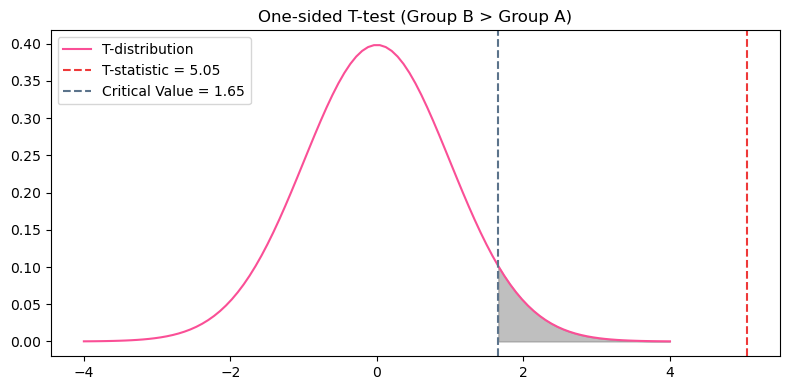

One-sided t-test statistic: 5.049519152060581


In [13]:

# One-sided t-test (right-tailed for the hypothesis that group B's mean is greater than group A's mean)
one_sided_test_p_right = two_sided_test.pvalue / 2 if two_sided_test.statistic > 0 else 1 - (two_sided_test.pvalue / 2)
one_sided_test_stat_right = two_sided_test.statistic

# Degrees of freedom
df = len(group_a) + len(group_b) - 2

# T-distribution plot
t_values = np.linspace(-4, 4, 100)
t_distribution = stats.t.pdf(t_values, df)

# Plotting both tests side-by-side
plt.figure(figsize=(10, 4))


# One-sided t-test (group B > group A) plot
# Plotting both tests side-by-side
plt.figure(figsize=(8, 4))
plt.subplot(1, 1, 1)
plt.plot(t_values, t_distribution, label="T-distribution", color=ppt_rasp)
plt.axvline(x=one_sided_test_stat_right, color=ppt_red, linestyle='--', label=f'T-statistic = {one_sided_test_stat_right:.2f}')
critical_value_one_sided_right = stats.t.ppf(0.95, df)
plt.axvline(x=critical_value_one_sided_right, color=ppt_grey, linestyle='--', label=f'Critical Value = {critical_value_one_sided_right:.2f}')
plt.fill_between(t_values, t_distribution, where=t_values > critical_value_one_sided_right, color='gray', alpha=0.5)
plt.title("One-sided T-test (Group B > Group A)")
plt.legend()

plt.tight_layout()
plt.show()

print("One-sided t-test statistic:", one_sided_test_stat_right)


In [14]:
# Perform one-sided t-test (we divide the p-value by 2 and check the sign of the statistic)
one_sided_test_p = two_sided_test.pvalue / 2 if two_sided_test.statistic < 0 else 1 - (two_sided_test.pvalue / 2)
one_sided_test_stat = two_sided_test.statistic

# Print the results
print("One-sided t-test statistic:", one_sided_test_stat)
print("One-sided t-test p-value:", one_sided_test_p)

One-sided t-test statistic: 5.049519152060581
One-sided t-test p-value: 0.9999994990887233


##### Plot Side-by-Side

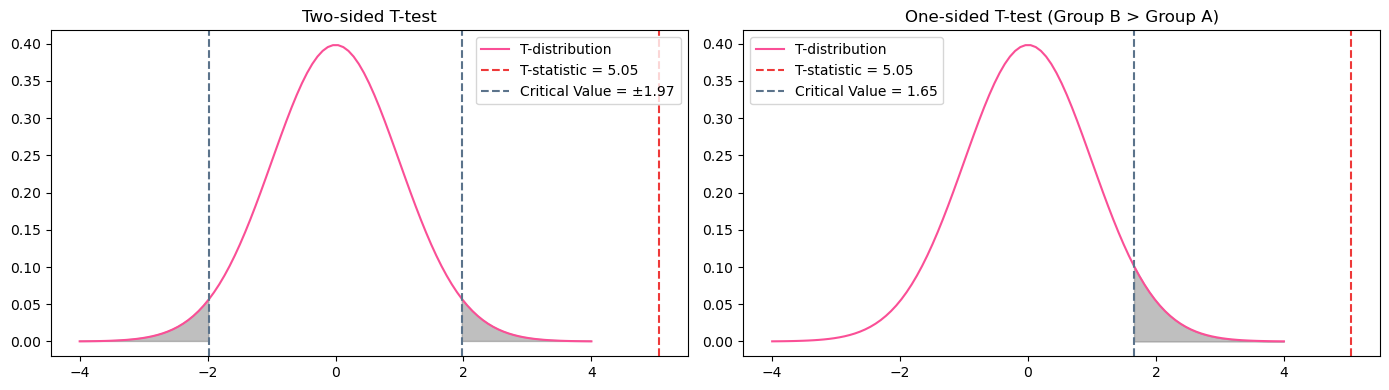

In [15]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


# Perform two-sided t-test
two_sided_test = stats.ttest_ind(group_b, group_a)  # Note the order of groups

# One-sided t-test (right-tailed for the hypothesis that group B's mean is greater than group A's mean)
one_sided_test_p_right = two_sided_test.pvalue / 2 if two_sided_test.statistic > 0 else 1 - (two_sided_test.pvalue / 2)
one_sided_test_stat_right = two_sided_test.statistic

# Degrees of freedom
df = len(group_a) + len(group_b) - 2

# T-distribution plot
t_values = np.linspace(-4, 4, 100)
t_distribution = stats.t.pdf(t_values, df)

# Plotting both tests side-by-side
plt.figure(figsize=(14, 4))

# Two-sided t-test plot
plt.subplot(1, 2, 1)
plt.plot(t_values, t_distribution, label="T-distribution", color=ppt_rasp)
plt.axvline(x=two_sided_test.statistic, color=ppt_red, linestyle='--', label=f'T-statistic = {two_sided_test.statistic:.2f}')
critical_value_two_sided = stats.t.ppf(1 - 0.025, df)
plt.axvline(x=critical_value_two_sided, color=ppt_grey, linestyle='--', label=f'Critical Value = ±{critical_value_two_sided:.2f}')
plt.axvline(x=-critical_value_two_sided, color=ppt_grey, linestyle='--')
plt.fill_between(t_values, t_distribution, where=(t_values < -critical_value_two_sided) | (t_values > critical_value_two_sided), color='gray', alpha=0.5)
plt.title("Two-sided T-test")
plt.legend()

# One-sided t-test (group B > group A) plot
plt.subplot(1, 2, 2)
plt.plot(t_values, t_distribution, label="T-distribution", color=ppt_rasp)
plt.axvline(x=one_sided_test_stat_right, color=ppt_red, linestyle='--', label=f'T-statistic = {one_sided_test_stat_right:.2f}')
critical_value_one_sided_right = stats.t.ppf(0.95, df)
plt.axvline(x=critical_value_one_sided_right, color=ppt_grey, linestyle='--', label=f'Critical Value = {critical_value_one_sided_right:.2f}')
plt.fill_between(t_values, t_distribution, where=t_values > critical_value_one_sided_right, color='gray', alpha=0.5)
plt.title("One-sided T-test (Group B > Group A)")
plt.legend()

plt.tight_layout()
plt.show()

It is importnat to note that the test statistic is the same for both the two-sided and one-sided t-tests in this scenario. The t-statistic itself is calculated based on the sample means, variances, and sample sizes of the two groups, and it does not change whether you're performing a two-sided or one-sided test.

What differs between the two-sided and one-sided tests is how the p-value is interpreted and how the critical values are determined:
- **Two-sided test**: The p-value reflects the probability of observing a test statistic as extreme as, or more extreme than, the observed value in either direction if the null hypothesis is true. The critical values are at both tails of the distribution.
- **One-sided test**: The p-value is halved (assuming the direction of the test aligns with the sign of the t-statistic), reflecting the probability of observing a test statistic as extreme as, or more extreme than, the observed value in the direction specified by the alternative hypothesis. The critical value is only on one side of the distribution.

The plots and calculations we've walked through above use the same test statistic, but they apply different critical values and interpret the p-values differently based on whether the test is one-sided or two-sided.

#### Confidence Intervals

In [16]:
# Calculate the standard error of the difference
std_a = np.std(group_a, ddof=1)  # Standard deviation of group A
std_b = np.std(group_b, ddof=1)  # Standard deviation of group B
n_a = len(group_a)  # Sample size of group A
n_b = len(group_b)  # Sample size of group B

se_diff = np.sqrt((std_a**2 / n_a) + (std_b**2 / n_b))

# Degrees of freedom
df = (n_a + n_b) - 2

# Critical t-value for 95% confidence interval
t_critical = stats.t.ppf(0.975, df)

# Confidence interval
lower_bound = difference_means - t_critical * se_diff
upper_bound = difference_means + t_critical * se_diff

# Print the confidence interval

print(f"95% Confidence Interval: Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f})")

95% Confidence Interval: Lower Bound: 3.69, Upper Bound: 8.42)


##### Plot Confidence Intervals

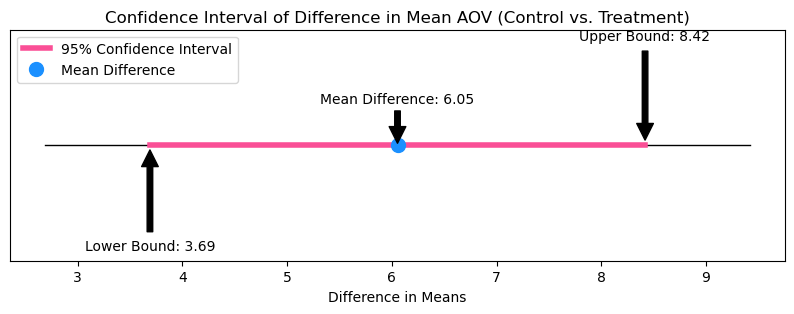

In [17]:
# Custom colors
ci_color = ppt_rasp  # Color for the confidence interval
mean_diff_color = ppt_blue  # Color for the mean difference marker

# Setting up the visualization with customizations
plt.figure(figsize=(10, 3))

# Number line from a bit less than the lower bound to a bit more than the upper bound
number_line_range = [lower_bound - 1, upper_bound + 1]
plt.plot(number_line_range, [0, 0], 'k-', lw=1)  # Draw the number line

# Plot the confidence interval as a dashed line
plt.plot([lower_bound, upper_bound], [0, 0], color=ci_color, linestyle='-', lw=4, label='95% Confidence Interval')  # Custom color and dashed

# Plot the mean difference as a larger, colored point
plt.plot(difference_means, 0, 'o', color=mean_diff_color, markersize=10, label='Mean Difference')  # Custom color and size

# Adding details to the plot
plt.title('Confidence Interval of Difference in Mean AOV (Control vs. Treatment)')
plt.xlabel('Difference in Means')
plt.yticks([])  # Remove y-axis marks
plt.legend(loc='upper left')

# Annotate the mean difference and the confidence interval bounds
plt.annotate(f'Mean Difference: {difference_means:.2f}', xy=(difference_means, 0), xytext=(difference_means, 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05), ha='center')
plt.annotate(f'Lower Bound: {lower_bound:.2f}', xy=(lower_bound, 0), xytext=(lower_bound, -0.05),
             arrowprops=dict(facecolor='black', shrink=0.05), ha='center')
plt.annotate(f'Upper Bound: {upper_bound:.2f}', xy=(upper_bound, 0), xytext=(upper_bound, 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

plt.show()


The 95% confidence interval for the difference in means between Group B and Group A is calculated using the following steps:

1. **Standard Error (SE) of the Difference:**

   $
   SE = \sqrt{\frac{s_A^2}{n_A} + \frac{s_B^2}{n_B}}
   $
   where $s_A$ and $s_B$ are the standard deviations of each group, and $n_A$ and $n_B$ are the sizes of each group. 
   
   For our data:
   - $s_A$ = 8,  $n_A$ = 100
   - $s_B$ = 10,  $n_B$ = 100
   
   - Therefore, 
   
   $ SE = \sqrt{\frac{8^2}{100} + \frac{10^2}{100}} = \sqrt{0.64 + 1.0} = \sqrt{1.64} \approx 1.28$

<br>

2. **Degrees of Freedom (df):**

   $
   df = n_A + n_B - 2 = 100 + 100 - 2 = 198
   $

3. **Critical t-value for 95% Confidence Level:**

   $
   t_{\text{critical}} = t_{0.975, 198} \approx 1.972
   $
   where 0.975 is the upper tail probability because it's a two-tailed test (95% in the middle and 2.5% in each tail).

4. **Calculate the Confidence Interval:**

   $
   \text{Difference in means} \pm (t_{\text{critical}} \times SE)
   $
   
   $
   6.05 \pm (1.972 \times 1.28) \approx 6.05 \pm 2.53
   $
   
   - Therefore, the 95% confidence interval is approximately \(6.05 - 2.53\) to \(6.05 + 2.53\), or \(3.52\) to \(8.58\).

Note: The actual computed values might slightly vary based on precise calculations of the standard error and exact critical t-value.

This confidence interval indicates that we are 95% confident that the true difference in the population means falls between \(3.52\) and \(8.58\).


### Summary

In [18]:
# print results
print(f"Average Order Value (Control): {mean_a:.2f}")
print(f"Average Order Value (Treatment): {mean_b:.2f}")
print(f"Incremental Gain (Treatment over Control): {difference_means:.2f}")
print(f"Lift (Treatment over Control): {lift_percentage:.2f}%")
print(f"95% Confidence Interval: Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f})")
print(f"p-value: {p_value:.5f}")

Average Order Value (Control): 74.17
Average Order Value (Treatment): 80.22
Incremental Gain (Treatment over Control): 6.05
Lift (Treatment over Control): 8.16%
95% Confidence Interval: Lower Bound: 3.69, Upper Bound: 8.42)
p-value: 0.00000
